In [3]:
import tensorflow as tf
import numpy as np
tf.config.list_physical_devices('GPU')
width = 224
height = 224

data_X_train = np.load("data/X_train.npy", allow_pickle=True)
data_y_train = np.load("data/y_train.npy", allow_pickle=True)
data_labels_train = np.load("data/labels_train.npy", allow_pickle=True)
#data_X_test = np.load("data/X_test.npy")
#data_y_test = np.load("data/y_test.npy")
print(data_X_train.shape)
print(data_y_train.shape)
print(data_labels_train.shape)


2025-12-03 20:27:46.202467: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(33402, 128, 128, 1)
(33402, 6, 4)
(33402, 6)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train_bboxes, y_val_bboxes, y_train_labels, y_val_labels = train_test_split(
    data_X_train, data_y_train, data_labels_train,
    test_size=0.2,
    random_state=5,
    shuffle=True
)
data_X_train = None
data_y_train = None
data_labels_train = None


In [5]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, {"bboxes": y_train_bboxes, "classes": y_train_labels}))
X_train = None
y_train_bboxes = None
y_train_labels = None
ds_val = tf.data.Dataset.from_tensor_slices((X_val, {"bboxes": y_val_bboxes, "classes": y_val_labels}))
X_val = None
y_val_bboxes = None
y_val_labels = None
ds_train = ds_train.shuffle(buffer_size=10000).batch(64).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(64).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1764786475.056541   65914 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4978 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6
2025-12-03 20:27:55.058933: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1751187456 exceeds 10% of free system memory.
2025-12-03 20:28:02.212310: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 1751187456 exceeds 10% of free system memory.
2025-12-03 20:28:03.923378: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 437846016 exceeds 10% of free system memory.
2025-12-03 20:28:04.502843: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 437846016 exceeds 10% of free system memory.


In [7]:
def lr_schedule(epoch):
    if epoch < 10:
        return 1e-5 + epoch * (1e-3 - 1e-4) / 10
    '''
    elif epoch < 30:
        return 1e-3
    elif epoch < 40:
        return 5e-4
    elif epoch < 45:
        return 1e-5
    else:
        return 1e-6
        '''
# TODO
def predModel(input_shape=(128,128,1), num_classes = 11, max_digits = 6):
    inputs = tf.keras.Input(shape=input_shape)
    #inputs = tf.keras.layers.RandomBrightness(0.2)(inputs)
    #inputs = tf.keras.layers.RandomContrast(0.2)(inputs)
    x = tf.keras.layers.Conv2D(32, (3,3), padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(256, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Conv2D(512, (3,3), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    #BBOX
    bbox = tf.keras.layers.Dense(128, activation='relu')(x)
    bbox = tf.keras.layers.Dropout(0.1)(bbox)
    bbox = tf.keras.layers.Dense(max_digits * 4)(bbox)
    bbox_output = tf.keras.layers.Reshape((max_digits, 4), name="bboxes")(bbox)

    #CLASSIFICATION
    #cls = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    #cls = tf.keras.layers.Dropout(0.2)(cls)
    cls = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    cls = tf.keras.layers.Dropout(0.4)(cls)
    cls = tf.keras.layers.Dense(max_digits * num_classes, activation='softmax')(cls)
    cls_output = tf.keras.layers.Reshape((max_digits, num_classes), name="classes")(cls)

    return tf.keras.Model(inputs, [bbox_output, cls_output])

model = predModel()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, amsgrad=True),
    loss={
        "bboxes": tf.losses.Huber(delta=0.05),
        "classes": "sparse_categorical_crossentropy"
    },
    loss_weights = {
        "bboxes": 0.05,
        "classes": 1.0
    },
    metrics={
        "bboxes": ["mse"],
        "classes": ["accuracy"]
    },
)


model.fit(
    ds_train,
    epochs=30,
    validation_data=ds_val,
    callbacks = [
        #tf.keras.callbacks.LearningRateScheduler(lr_schedule),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classes_accuracy', factor=0.3, patience=3,min_lr=1e-6, mode='max'),
        tf.keras.callbacks.EarlyStopping(monitor='val_classes_accuracy', patience=10, restore_best_weights=True, mode='max'),
        #tf.keras.callbacks.EarlyStopping(monitor='val_bboxes_mse', patience=7, restore_best_weights=True, mode='min')
    ]
)





Epoch 1/30


2025-12-03 20:29:17.501149: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-03 20:29:17.963573: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


417/418 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - bboxes_loss: 0.0036 - bboxes_mse: 0.0237 - classes_accuracy: 0.6469 - classes_loss: 1.1309 - loss: 1.1607

2025-12-03 20:29:34.370432: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-03 20:29:34.762150: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-03 20:29:35.260758: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 100 bytes spill stores, 100 bytes spill loads



418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - bboxes_loss: 0.0036 - bboxes_mse: 0.0237 - classes_accuracy: 0.6470 - classes_loss: 1.1307 - loss: 1.1604

2025-12-03 20:29:39.340567: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-12-03 20:29:41.313288: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


418/418 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - bboxes_loss: 0.0024 - bboxes_mse: 0.0137 - classes_accuracy: 0.6742 - classes_loss: 1.0161 - loss: 1.0434 - val_bboxes_loss: 0.0062 - val_bboxes_mse: 0.0494 - val_classes_accuracy: 0.6811 - val_classes_loss: 1.9585 - val_loss: 1.9826 - learning_rate: 5.0000e-04
Epoch 2/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - bboxes_loss: 0.0016 - bboxes_mse: 0.0085 - classes_accuracy: 0.7073 - classes_loss: 0.9007 - loss: 0.9224 - val_bboxes_loss: 0.0020 - val_bboxes_mse: 0.0127 - val_classes_accuracy: 0.6929 - val_classes_loss: 1.1698 - val_loss: 1.1901 - learning_rate: 5.0000e-04
Epoch 3/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - bboxes_loss: 0.0013 - bboxes_mse: 0.0071 - classes_accuracy: 0.7439 - classes_loss: 0.7891 - loss: 0.8083 - val_bboxes_loss: 0.0015 - val_bboxes_mse: 0.0081 - val_classes_accuracy: 0.7304 - val_classes_loss: 0.8657 - val_loss: 0.8841 - learning_rate: 5.0000e-04
Epoch 4/30
418/418 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - b

In [8]:
results = model.evaluate(ds_val)
print(results)
print('Test loss: %.4f accuracy: %.4f' % (results[2], results[4]))

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - bboxes_loss: 8.3675e-04 - bboxes_mse: 0.0042 - classes_accuracy: 0.8847 - classes_loss: 0.3916 - loss: 0.4108
[0.41079387068748474, 0.0008367497357539833, 0.3915703296661377, 0.004204998724162579, 0.8847476243972778]
Test loss: 0.3916 accuracy: 0.8847


In [9]:
data_X_test = np.load("data/X_test.npy", allow_pickle=True)
data_y_test = np.load("data/y_test.npy", allow_pickle=True)
data_labels_test = np.load("data/labels_test.npy", allow_pickle=True)
print(data_X_test.shape)
print(data_y_test.shape)
print(data_labels_test.shape)
ds_test = tf.data.Dataset.from_tensor_slices((data_X_test, {"bboxes": data_y_test, "classes": data_labels_test}))
ds_test = ds_test.batch(64).prefetch(tf.data.AUTOTUNE)


(13068, 128, 128, 1)
(13068, 6, 4)
(13068, 6)


In [10]:
results = model.evaluate(ds_test)
print(results)
print('Test loss: %.4f accuracy: %.4f' % (results[2], results[4]))
data_X_test = None
data_y_test = None
data_labels_test = None
ds_test = None

204/205 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - bboxes_loss: 0.0012 - bboxes_mse: 0.0059 - classes_accuracy: 0.8327 - classes_loss: 0.6190 - loss: 0.6384

2025-12-03 20:36:10.740622: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - bboxes_loss: 0.0012 - bboxes_mse: 0.0059 - classes_accuracy: 0.8338 - classes_loss: 0.6148 - loss: 0.6337
[0.6337229013442993, 0.0012021443108096719, 0.614774227142334, 0.005884596612304449, 0.8337796926498413]
Test loss: 0.6148 accuracy: 0.8338


In [ ]:
#model.save('models/svhnModel.keras')

In [ ]:
'''
# Build a simple neural network model
model = tf.keras.Sequential([
#   tf.keras.Input(shape=(32, 32, 3)),
    tf.keras.layers.Resizing(48, 48, pad_to_aspect_ratio = True, fill_mode='constant', fill_value=0.0),
#    tf.keras.layers.Rescaling(scale = 1./255),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
X_train = np.transpose(data_X_train, (3,0,1,2))
y_train = data_y_train.reshape(-1)
X_test = np.transpose(data_X_test, (3,0,1,2))
y_test = data_y_test.reshape(-1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
ds_train = ds_train.shuffle(buffer_size=10000).batch(128).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.batch(128).prefetch(tf.data.AUTOTUNE)

# Train and validate

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)
'''

dict_keys(['bboxes_loss', 'bboxes_mse', 'classes_accuracy', 'classes_loss', 'loss', 'val_bboxes_loss', 'val_bboxes_mse', 'val_classes_accuracy', 'val_classes_loss', 'val_loss', 'learning_rate'])


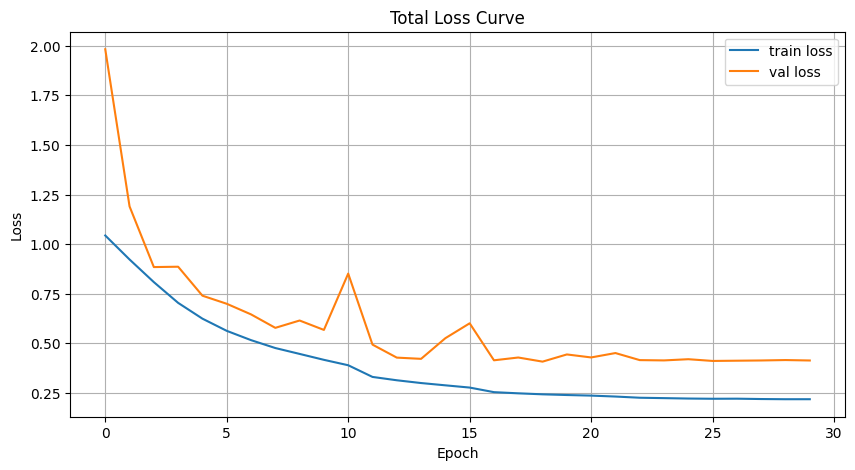

In [11]:
print(model.history.history.keys())
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(model.history.history['loss'], label = 'train loss')
plt.plot(model.history.history['val_loss'], label = 'val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss Curve')
plt.legend()
plt.grid()
plt.show()

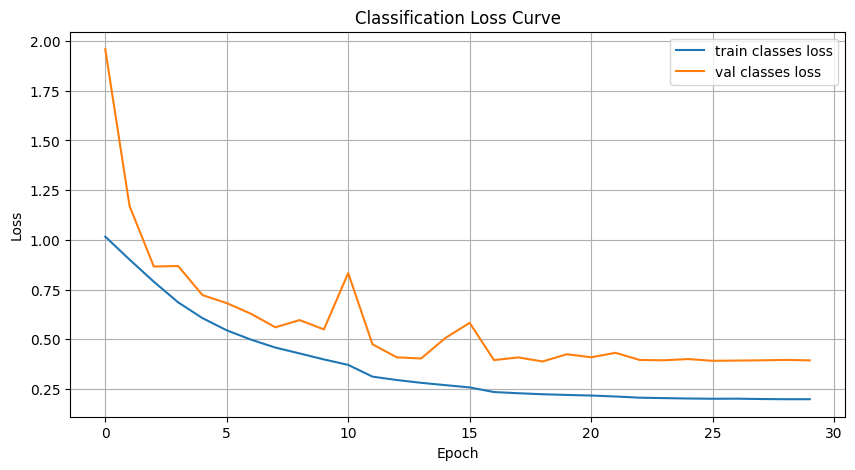

In [12]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['classes_loss'], label = 'train classes loss')
plt.plot(model.history.history['val_classes_loss'], label = 'val classes loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss Curve')
plt.legend()
plt.grid()
plt.show()

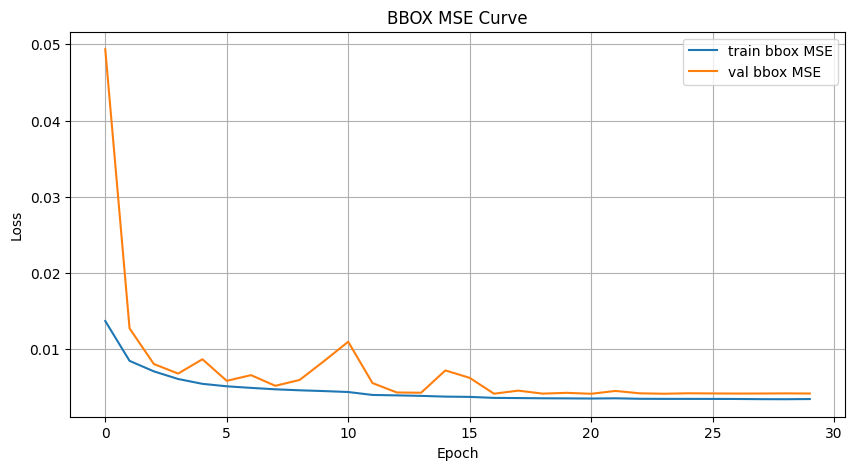

In [13]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['bboxes_mse'], label = 'train bbox MSE')
plt.plot(model.history.history['val_bboxes_mse'], label = 'val bbox MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BBOX MSE Curve')
plt.legend()
plt.grid()
plt.show()


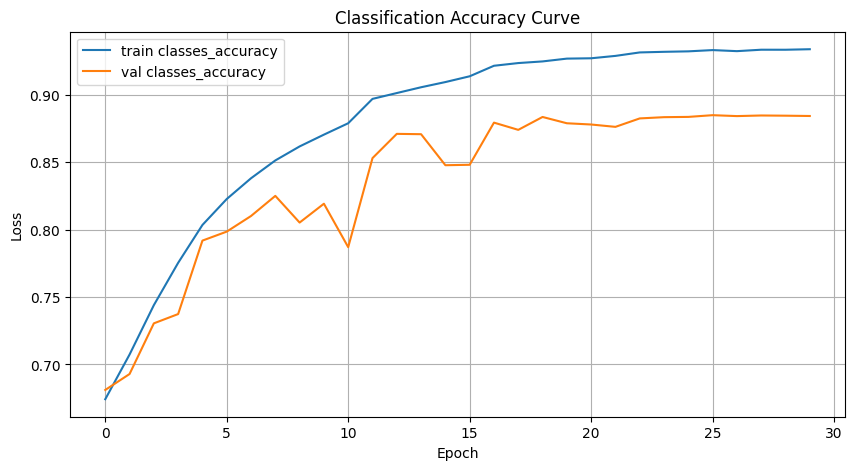

In [14]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['classes_accuracy'], label = 'train classes_accuracy')
plt.plot(model.history.history['val_classes_accuracy'], label = 'val classes_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Accuracy Curve')
plt.legend()
plt.grid()
plt.show()


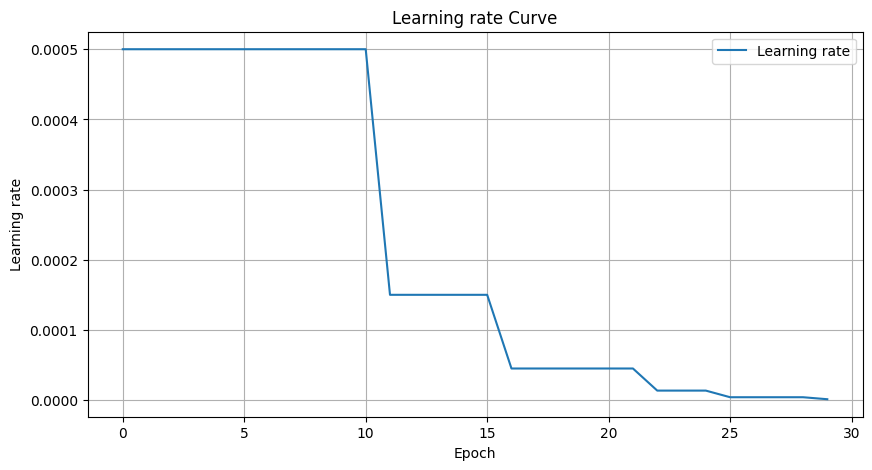

In [15]:
plt.figure(figsize=(10,5))
plt.plot(model.history.history['learning_rate'], label = 'Learning rate')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.title('Learning rate Curve')
plt.legend()
plt.grid()
plt.show()

In [115]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_508CL… │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 128, 128,  │        320 │ keras_tensor_508… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_80[1][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_80 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_64    │ (None, 64, 64,    │          0 │ re_lu_80[1][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_64… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_81[1][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_81 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_65    │ (None, 32, 32,    │          0 │ re_lu_81[1][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_65… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_82[1][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_82 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_66    │ (None, 16, 16,    │          0 │ re_lu_82[1][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 16, 16,    │    295,168 │ max_pooling2d_66… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_83[1][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_83 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_67    │ (None, 8, 8, 256) │          0 │ re_lu_83[1][0]  

 Total params: 6,853,674 (26.14 MB)

 Trainable params: 1,712,922 (6.53 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 5,138,768 (19.60 MB)

In [116]:
model.history.history

{'bboxes_loss': [0.00237061339430511,
  0.001581721706315875,
  0.0013158275978639722,
  0.0011404446559026837,
  0.0010604403214529157,
  0.001008608378469944,
  0.000976423267275095,
  0.0009455584804527462,
  0.0009274173062294722,
  0.0009061075397767127,
  0.0008936841040849686,
  0.000873052456881851,
  0.0008658550214022398,
  0.0008579391287639737,
  0.0008413483737967908,
  0.0008230016101151705,
  0.0008095429511740804,
  0.0007979444344528019],
 'bboxes_mse': [0.014340396970510483,
  0.009045690298080444,
  0.006836897227913141,
  0.006011272314935923,
  0.005613852292299271,
  0.005343375261873007,
  0.005152365658432245,
  0.0049692923203110695,
  0.004844641778618097,
  0.004707846790552139,
  0.0046300324611365795,
  0.004474535118788481,
  0.004434224683791399,
  0.004379096440970898,
  0.004273355007171631,
  0.004122499376535416,
  0.0040459828451275826,
  0.003948434721678495],
 'classes_accuracy': [0.6742883920669556,
  0.7084000110626221,
  0.7458241581916809,
  0.